# LPPUFv1 Reliability Correlation Analysis Layer 3

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import pypuf.batch
import pypuf.metrics

from lppuf import LPPUFv1

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [3]:
%%bash
mkdir -p results/v1/reliability-correlation-layer-3

In [4]:
results = pypuf.batch.FilesystemResultCollection('results/v1/reliabilty-correlation-layer-3')

In [5]:
class LPPUFv1ReliabilityCorellationLayer3Analysis(pypuf.batch.StudyBase):
    
    def parameter_matrix(self):
        return [
            dict(
                n=n,
                noisiness_1=noisiness_1,
                noisiness_2=noisiness_2,
                seed=seed,
                m=m,
            )
            for n in [64]
            for noisiness_1 in [.1]  # .1 selected for design
            for noisiness_2 in [0, .01]
            for seed in range(30)
            for m in [1, 2, 4, 8, 16]
        ]
    
    def run(self, n, noisiness_1, noisiness_2, seed, m):
        puf = LPPUFv1(n=n, m=m, noisiness_1=noisiness_1, noisiness_2=noisiness_2, seed=seed)
        pufa = LPPUFv1(n=n, m=m, noisiness_1=noisiness_1, noisiness_2=noisiness_2, seed=seed+1)
        
        r = 5
        N = 1000
        
        # generate overall CRPs
        challenges = pypuf.io.random_inputs(n=n, N=N, seed=1)
        
        # guess CRPs for layer 3
        guessed_layer1_responses = pypuf.io.random_inputs(n=m, N=N, seed=2)
        guessed_layer2_inputs = np.concatenate((challenges, guessed_layer1_responses), axis=1)
        guessed_layer3_inputs = puf.layer[1].eval(guessed_layer2_inputs)  # using puf instance function for convenience, but actually only public info

        # reliability of layer 3 on guessed responses compared to LP-PUF and unrelated LP-PUF
        r1 = np.average(puf.layer[2].r_eval(r=r, challenges=guessed_layer3_inputs), axis=-1)
        r2 = np.average(puf.r_eval(r=r, challenges=challenges), axis=-1)
        r2a = np.average(pufa.r_eval(r=r, challenges=challenges), axis=-1)
        
        return {
            'rcorr': sp.stats.pearsonr(r1[:, 0], r2[: , 0])[0],
            'rcorra': sp.stats.pearsonr(r1[:, 0], r2a[: , 0])[0],
        } 

In [6]:
study = LPPUFv1ReliabilityCorellationLayer3Analysis(results)

In [7]:
study.run_all()

DEBUG:root:LPPUFv1ReliabilityCorellationLayer3Analysis: running 0 unfinished jobs from a batch of 300 (300 of this batch already completed, batch total 300, study total 300 jobs)


In [8]:
import pandas as pd

In [9]:
data = pd.DataFrame(results.load_all())

In [10]:
data['rcorr_abs_max'] = data.apply(lambda row: np.abs(row['rcorr']).max(), axis=1)
data['rcorr_abs_avg'] = data.apply(lambda row: np.abs(row['rcorr']).mean(), axis=1)
data['rcorra_abs_max'] = data.apply(lambda row: np.abs(row['rcorra']).max(), axis=1)
data['rcorra_abs_avg'] = data.apply(lambda row: np.abs(row['rcorra']).mean(), axis=1)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data['LP-PUF Overall Reliability'] = data['rcorr_abs_max']
data['Unrelated LP-PUF Overall Reliability'] = data['rcorra_abs_max']
melted_data = data[data.iloc[0]['parameters']+['LP-PUF Overall Reliability', 'Unrelated LP-PUF Overall Reliability']].melt(
    id_vars=data.iloc[0]['parameters'], 
    var_name='Correlation of Layer 3 reliability under guessed challenges with', 
    value_name='correlation',
)
melted_data

,n,noisiness_1,noisiness_2,seed,m,Correlation of Layer 3 reliability under guessed challenges with,correlation
0,64,0.1,0.00,9,16,LP-PUF Overall Reliability,0.008149
1,64,0.1,0.01,1,4,LP-PUF Overall Reliability,0.158817
2,64,0.1,0.00,10,4,LP-PUF Overall Reliability,0.120844
3,64,0.1,0.01,12,4,LP-PUF Overall Reliability,0.113856
4,64,0.1,0.01,22,4,LP-PUF Overall Reliability,0.090663
...,...,...,...,...,...,...,...
595,64,0.1,0.01,28,1,Unrelated LP-PUF Overall Reliability,0.114546
596,64,0.1,0.00,16,8,Unrelated LP-PUF Overall Reliability,0.031138
597,64,0.1,0.01,21,8,Unrelated LP-PUF Overall Reliability,0.007521
598,64,0.1,0.00,15,2,Unrelated LP-PUF Overall Reliability,0.006907


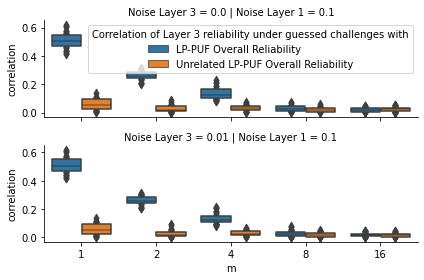

In [20]:
melted_data['Noise Layer 1'] = melted_data['noisiness_1']
melted_data['Noise Layer 3'] = melted_data['noisiness_2']

g = sns.catplot(
    data=melted_data,
    x='m',
    y='correlation',
    hue='Correlation of Layer 3 reliability under guessed challenges with',
    row='Noise Layer 3',
    col='Noise Layer 1',
    kind='boxen',
    aspect=3/1,
    height=2,
    legend_out=False
)
g.tight_layout()
g.savefig('figures/lppufv1-reliability-correlation-layer-3.pdf')

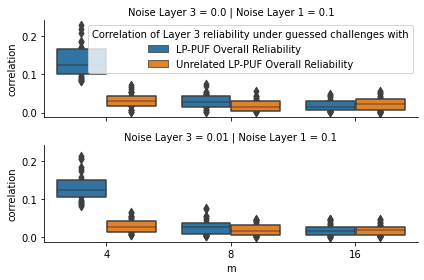

In [21]:
g = sns.catplot(
    data=melted_data[melted_data['m'] >= 4],
    x='m',
    y='correlation',
    hue='Correlation of Layer 3 reliability under guessed challenges with',
    row='Noise Layer 3',
    col='Noise Layer 1',
    kind='boxen',
    aspect=3/1,
    height=2,
    legend_out=False,
)
g.tight_layout()
g.savefig('figures/lppufv1-reliability-correlation-layer-3-zoomed.pdf')